### Colin Alberts

## 0: Importing Packages and Defining Variables

### 0.0: Importing Packages

In [40]:
import numpy as np
import sympy as sp
import copy

import matplotlib.pyplot as plt
from matplotlib import cm

### 0.1: Defining Variables

In [41]:
T = 1. # expiry time
r = 0.1 # no-risk interest rate
sigma = 0.2 # volatility of underlying asset
delta = 0.0 # dividend rate
E = 70. # exercise price
S_max = 100#2 * E # upper bound of price of the stock (4*E)
S_min = 0 # this is redundant
N = 100 # time iterations
M = 50 # space iterations
option_type = "Call"

# time grid
t, ht = np.linspace(start = 0,
                    stop = T,
                    num = N + 1,
                    retstep = True)

# spatial grid (stock's price)
s, ds = np.linspace(0, 
                    S_max, 
                    M + 1, 
                    retstep = True)

def initial_condition(x, option):
    x_copy = x
        
    if option == 'Call':
        x_copy[:, -1] = np.maximum(s - E, 0)
        x_copy[0, :] = 0
        x_copy[-1, :] = np.exp(-r * (T - t)) * (S_max - E)
    elif option == 'Put':
        x_copy[:, -1] = np.maximum(E - s, 0)
        x_copy[0, :] = np.exp(-r * (T - t)) * (E - S_min)
        x_copy[-1, :] = 0

    return x_copy

# solution grid
solution = np.zeros(shape = (M + 1, N + 1))
solution = initial_condition(solution, option_type)


### 0.2: Optimization Functions

In [42]:
# Thomas Algorithm

def thomas(a, b, c, d):
    # Solves a tridiagonal system of equations, i.e Ax = b, where A is tridiagonal.
    # Is faster than np.linalg.solve(). Returns x
    
    dim = len(d)  # nr of equations to be solved
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    
    for i in range(1, dim):
        w = ac[i - 1] / bc[i - 1]
        print(w)
        bc[i] = bc[i] - w * cc[i - 1]
        dc[i] = dc[i] - w * dc[i - 1]
        
    x = bc
    x[-1] = dc[-1] / bc[-1]

    for j in range(dim - 2, -1, -1):
        x[j] = (dc[j] - cc[j] * x[j + 1]) / bc[j]
        
    return x

# 1: Crank-Nicolson Implementation

## 1.1: Constructing Matrices

The [link](https://github.com/katpirat/Finite-difference-for-PDEs/blob/main/FD_for_BlackScholes_pricing.py) to the source that I ~~stole~~ took implementation inspiration from.

In [43]:
def crank():
    crank_solution = copy.deepcopy(solution)
    
    u_vec = ht / 4 * (sigma ** 2 * s ** 2 - r * s)
    v_vec = ht / 2 * (sigma ** 2 * s ** 2 + r - delta)
    w_vec = ht / 4 * (sigma ** 2 * s ** 2 + r * s)

    P_mat = np.diag(-u_vec[2:-1], -1) + np.diag(v_vec[1:-1] + 1) + np.diag(-w_vec[1:-2], 1)
    Q_mat = np.diag(u_vec[2:-1], -1) + np.diag(1 - v_vec[1:-1]) +  np.diag(w_vec[1:-2], 1)
    
    offset_1 = np.zeros(M - 1)
    offset_2 = np.zeros(M - 1)
    
    for i in range(N, 0, -1):
        offset_1[0] = crank_solution[0, i] * u_vec[1]
        offset_1[-1] = crank_solution[-1, i] * w_vec[-1]

        offset_2[0] = crank_solution[0, i - 1] * u_vec[1]
        offset_2[-1] = crank_solution[-1, i - 1] * w_vec[-1]
        
        RHS = Q_mat @ crank_solution[1:-1, i] - (offset_1 + offset_2)
        
        # crank_solution[1:-1, i - 1] = thomas(np.diag(-u_vec[2:-1], -1),
        #                                      np.diag(v_vec[1:-1] + 1),
        #                                      np.diag(-w_vec[1:-2], 1),
        #                                      RHS)
        crank_solution[1:-1, i - 1] = np.linalg.solve(P_mat, RHS)
    
    # c_names = [str(self.time_min + self.dt * i) for i in range(self.time_steps + 1)]
    # df = pd.DataFrame(res, columns=c_names)
    # self.calculated = df

    return crank_solution

## 1.2: Plot Function

In [44]:
def surface_plot(solution):
    fig = plt.figure(figsize=(40, 6))
    ax2 = fig.add_subplot(111, projection="3d")
    X, Y = np.meshgrid(t, s)
    ax2.plot_surface(Y, X, solution, cmap=cm.ocean)
    ax2.set_title("Price Surface")
    ax2.set_xlabel("S")
    ax2.set_ylabel("t")
    ax2.set_zlabel("V")
    if option_type == 'Call':
        ax2.view_init(30, 140)  # this function rotates the 3d plot
    if option_type == 'Put':
        ax2.view_init(30, 30)
    plt.show()

## 1.3: Solve and Plot

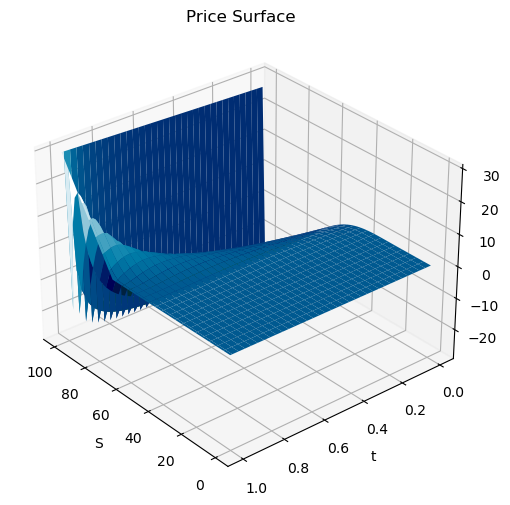

In [45]:
plot_solution = crank()
surface_plot(plot_solution)

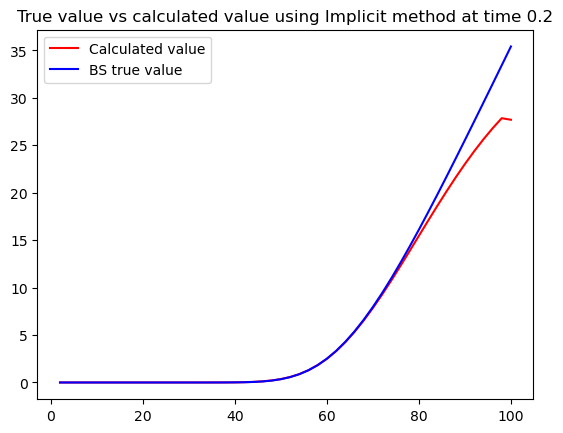

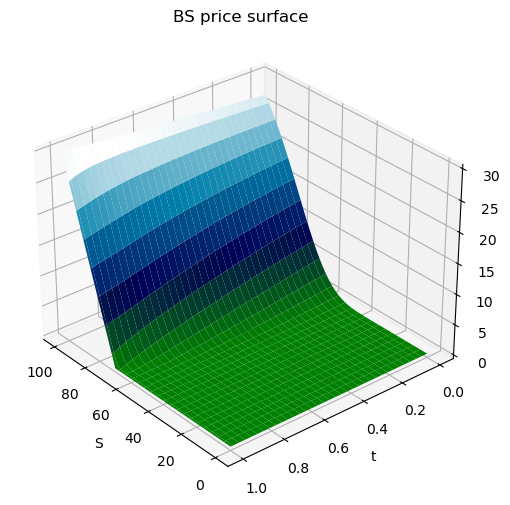

In [46]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm

class finite_difference_methods:
    def __init__(self, time_steps, state_steps, time_min, time_max, state_min, state_max, r, sigma, K, payoff = 'Call'):
        self.payoff = payoff
        self.time_steps = time_steps
        self.state_steps = state_steps
        self.time_min = time_min
        self.time_max = time_max
        self.state_min = state_min
        self.state_max = state_max
        self.K = K
        self.r = r
        self.sigma = sigma
        self.grid = np.zeros(
            shape = (state_steps+1, time_steps+1)
        )
        self.x_grid, self.dx = np.linspace(start = state_min,
            stop = state_max,
            num = state_steps+1,
            retstep=True)
        self.t_grid, self.dt = np.linspace(
            start = time_min,
            stop = time_max,
            num = time_steps+1,
            retstep = True
        )
        self.lambda_ = self.dt / self.dx ** 2

        self.grid = self.initial_cond(self.grid)
        self.calculated = None
        self.method = None

    def thomas_algorithm(self, a, b, c, d):
        # Solves a tridiagonal system of equations, i.e Ax = b, where A is tridiagonal.
        # Is faster than np.linalg.solve(). Returns x
        dim = len(d)  # nr of equations to be solved
        ac, bc, cc, dc = map(np.array, (a, b, c, d))
        for i in range(1, dim):
            w = ac[i - 1] / bc[i - 1]
            bc[i] = bc[i] - w * cc[i - 1]
            dc[i] = dc[i] - w * dc[i - 1]
        x = bc
        x[-1] = dc[-1] / bc[-1]

        for j in range(dim - 2, -1, -1):
            x[j] = (dc[j] - cc[j] * x[j + 1]) / bc[j]
        return x

    def tridiag(self, a, b, c, k1=-1, k2=0, k3=1):
        # Creates a tridiagonal matrix with b in the diagonal, a in the subdiagonal and c in the superdiagonal
        return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

    def initial_cond(self, x):
        '''
        :param x:
            empty np.array defined in the constructor
        :return:
            np.array with boundaries given the option type ( Call or Put)
        '''
        temp = x
        if self.payoff == 'Call':
            temp[:, -1] = np.maximum(self.x_grid-self.K, 0)
            temp[0, :] = 0
            temp[-1, :] = np.exp(-self.r * (self.time_max - self.t_grid)) * (self.state_max - self.K)
        if self.payoff == 'Put':
            temp[:, -1] = np.maximum(self.K-self.x_grid, 0)
            temp[0, :] = np.exp(-self.r * (self.time_max - self.t_grid)) * (self.K - self.state_min)
            temp[-1, :] = 0

        return temp

    def true_val(self, t):
        '''
        :param t:
            int time
        :return:
            Black-Scholes price for given time.
        '''
        d1 = (np.log(self.x_grid[1:]/self.K) + (self.r + self.sigma**2/2) * (self.time_max-t))/(self.sigma*np.sqrt(self.time_max-t))
        d2 = d1 - self.sigma * np.sqrt(self.time_max-t)
        if self.payoff == 'Call':
            res = self.x_grid[1:] * norm.cdf(d1) - self.K * np.exp(-self.r * (self.time_max-t)) * norm.cdf(d2)
        if self.payoff == 'Put':
            res = self.K * np.exp(-self.r * (self.time_max-t)) * norm.cdf(-d2) - self.x_grid[1:] * norm.cdf(-d1)
        return res

    def plot_with_true(self, t):
        '''

        :param t:
            int time.
        :return:
            Plots the calculated FD method against the Black-Scholes true option price at time t.

        '''
        if self.calculated is None:
            raise Exception('The class has not calculated any results yes.')
        plt.plot(self.x_grid[1:], self.calculated[str(t)][1:], 'r-', label = 'Calculated value')
        true = self.true_val(t)
        plt.plot(self.x_grid[1:], true, 'b', label = 'BS true value')
        if self.payoff == 'Call':
            plt.legend(loc="upper left")
        if self.payoff == 'Put':
            plt.legend(loc="upper right")

        plt.title(f'True value vs calculated value using {self.method} method at time {t}')
        plt.show()

    def surface_plot(self):
        '''
        :return:
            3d plot of the volatility surface using a finite difference method.
        '''
        if self.calculated is None:
            raise Exception('Use one of the methods to solve the grid before plotting.')
        fig = plt.figure(figsize=(40, 6))
        ax2 = fig.add_subplot(111, projection="3d")
        X, Y = np.meshgrid(self.t_grid, self.x_grid)
        ax2.plot_surface(Y, X, self.calculated, cmap=cm.ocean)
        ax2.set_title("BS price surface")
        ax2.set_xlabel("S")
        ax2.set_ylabel("t")
        ax2.set_zlabel("V")
        if self.payoff == 'Call':
            ax2.view_init(30, 140)  # this function rotates the 3d plot
        if self.payoff == 'Put':
            ax2.view_init(30, 30)
        plt.show()

    def explicit_method(self):
        self.method = 'Explicit'
        res = copy.deepcopy(self.grid)

        a_vec = -(self.sigma**2 * self.x_grid**2)/(2 * (self.dx**2)) + (self.r * self.x_grid)/(2 * self.dx)
        b_vec = self.r + (self.sigma**2 * self.x_grid**2)/(self.dx**2)
        c_vec = -(self.sigma**2 * self.x_grid**2)/(2 * (self.dx**2)) - (self.r * self.x_grid)/(2 * self.dx)
        A = self.tridiag(
            a_vec[2:-1],
            b_vec[1:-1],
            c_vec[1:-2]
        )

        I = np.identity(self.state_steps-1)
        offset = np.zeros(self.state_steps - 1)
        n = np.linalg.norm(I - A, np.inf)
        for i in range(self.time_steps, 0, -1):
            offset[0] = res[0, i] * a_vec[1]
            offset[-1] = res[-1, i] * c_vec[-1]
            res[1:-1, i-1] = np.dot(I - A * self.dt, res[1:-1, i]) - self.dt * offset


        c_names = [str(self.time_min + self.dt * i) for i in range(self.time_steps + 1)]
        df = pd.DataFrame(res, columns=c_names)
        self.calculated = df

        return res

    def implicit_method(self):
        self.method = 'Implicit'
        res = copy.deepcopy(self.grid)

        a_vec = -(self.sigma ** 2 * self.x_grid ** 2) / (2 * (self.dx ** 2)) + (self.r * self.x_grid) / (2 * self.dx)
        b_vec = self.r + (self.sigma ** 2 * self.x_grid ** 2) / (self.dx ** 2)
        c_vec = -(self.sigma ** 2 * self.x_grid ** 2) / (2 * (self.dx ** 2)) - (self.r * self.x_grid) / (2 * self.dx)
        A = self.tridiag(
            a_vec[2:-1],
            b_vec[1:-1],
            c_vec[1:-2]
        )
        I = np.identity(self.state_steps - 1)
        offset = np.zeros(self.state_steps - 1)
        temp = I + A * self.dt
        for i in range(self.time_steps, 0, -1):
            offset[0] = res[0, i] * a_vec[1]
            offset[-1] = res[-1, i] * c_vec[-1]
            res[1:-1, i-1] = self.thomas_algorithm(
                np.diag(temp, -1),
                np.diag(temp),
                np.diag(temp, 1),
                res[1:-1, i] - self.dt * offset
            )

        c_names = [str(self.time_min + self.dt * i) for i in range(self.time_steps + 1)]
        df = pd.DataFrame(res, columns=c_names)
        self.calculated = df

        return res

    def crank_nicolson(self):
        self.method = 'Crank-Nicolson'
        res = copy.deepcopy(self.grid)

        a_vec = -(self.sigma ** 2 * self.x_grid ** 2) / (2 * (self.dx ** 2)) + (self.r * self.x_grid) / (2 * self.dx)
        b_vec = self.r + (self.sigma ** 2 * self.x_grid ** 2) / (self.dx ** 2)
        c_vec = -(self.sigma ** 2 * self.x_grid ** 2) / (2 * (self.dx ** 2)) - (self.r * self.x_grid) / (2 * self.dx)
        A = self.tridiag(
            a_vec[2:-1],
            b_vec[1:-1],
            c_vec[1:-2]
        )
        I = np.identity(self.state_steps - 1)
        offset_1 = np.zeros(self.state_steps - 1)
        offset_2 = np.zeros(self.state_steps - 1)

        temp = I + 1/2 * A * self.dt
        for i in range(self.time_steps, 0, -1):

            offset_1[0] = res[0, i] * a_vec[1]
            offset_1[-1] = res[-1, i] * c_vec[-1]

            offset_2[0] = res[0, i - 1] * a_vec[1]
            offset_2[-1] = res[-1, i - 1] * c_vec[-1]

            RHS = np.dot((I - 1/2 * A * self.dt), res[1:-1, i]) - 1/2 * self.dt * (offset_1 + offset_2)

            res[1:-1, i - 1] = self.thomas_algorithm(
                np.diag(temp, -1),
                np.diag(temp),
                np.diag(temp, 1),
                RHS
            )

        c_names = [str(self.time_min + self.dt * i) for i in range(self.time_steps + 1)]
        df = pd.DataFrame(res, columns=c_names)
        self.calculated = df

        return res
#time_steps, state_steps, time_min, time_max, state_min, state_max, r, sigma, K, payoff = 'Call'

'''
Class for solving the Black-Scholes PDE using different finite difference schemes. 
The class finite_difference_methods takes the following arguments: 

    time_steps(int). nr of time steps when creating the grid. 
    state_steps(int). nr of state steps when creating the grid. 
    time_min(float). Time start. 
    time_max(float). Time when payoff id realised. Used to implement the boundaries
    state_min(float). Minimum stock(or state) in the grid. 
    state_max(float). Maximum stock(or state) in the grid. 
    r(float). Interest rate in the model. 
    sigma(float). The vollatility in the model.
    K(float). Strike of the option. 
    payoff(str). Can be Call of Put. 
    
Example usage below. 
'''
finite_difference_solutions = finite_difference_methods(
    100, # Timesteps
    50, # Statesteps
    0, # Time min
    1, # time max
    0, # state min
    100,  # state_max
    0.1, # r
    0.2, # sigma
    70, # K,
    payoff = 'Call'
)

finite_difference_solutions.implicit_method()
finite_difference_solutions.plot_with_true(0.2)
finite_difference_solutions.surface_plot()